In [1]:
import pandas as pd 
import numpy as np 
import re

import torch 
import torch.nn as nn

# Stability Prediction of Enzymes using PyTorch RNNs and TensorFlow

Using Recurrent Neural Networks and computational feature engineering to compute and predict the thermodynamical stability of enzymes.

In [2]:
def load_fixed_dataframe(original = "train.csv", updated = "train_updates_20220929.csv", was_fixed = False):

    def fix_tm_ph(row, update_map):
        update_vals = update_map.get(row["seq_id"], None)
        if update_vals is not None:
            row["tm"] = update_vals["tm"]
            row["pH"] = update_vals["pH"]
        return row
    
    df = pd.read_csv(original)
    updated_df = pd.read_csv(updated)
    seq_id_phtm = updated_df[~pd.isna(updated_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    bad_seqs = updated_df[pd.isna(updated_df["pH"])]["seq_id"].to_list()

    df = df[~df["seq_id"].isin(bad_seqs)].reset_index(drop = True)
    df = df.apply(lambda x : fix_tm_ph(x, seq_id_phtm), axis = 1)

    if was_fixed: df["was_fixed"] = df["seq_id"].isin(bad_seqs + list(seq_id_phtm.keys()))
    return df 

test_df = pd.read_csv("test.csv")
train_df = load_fixed_dataframe()
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head(n=5)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [4]:
from sklearn.model_selection import train_test_split 

X, y = train_df.drop(["tm", "seq_id", "data_source"], axis = 1), train_df["tm"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

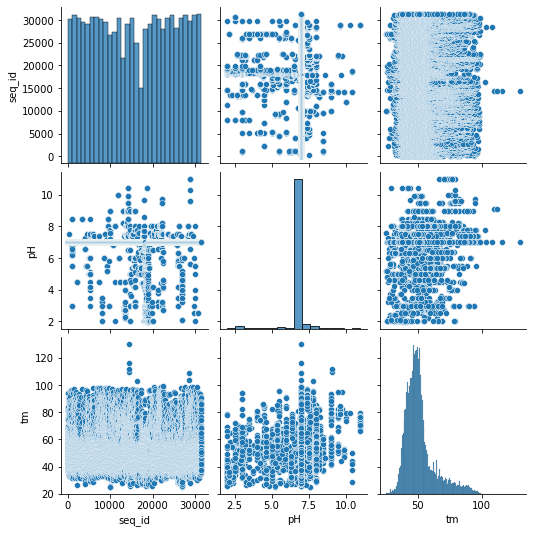

In [6]:
import seaborn as sns
sns.pairplot(train_df)

In [7]:
train_df["protein_length"] = train_df["protein_sequence"].apply(lambda x : len(x))
test_df["protein_length"] = test_df["protein_sequence"].apply(lambda x : len(x))

In [13]:
# Using a simple Support Vector Machine 

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

train_df = train_df.dropna()
label_enc = preprocessing.LabelEncoder()

modified_X, modified_y = np.array(train_df.drop(["seq_id", "protein_sequence", "data_source", "tm"], axis = 1)), np.array(train_df["tm"]).reshape(-1, 1)

array([[75.7],
       [50.5],
       [40.5],
       ...,
       [64.6],
       [50.7],
       [37.6]])

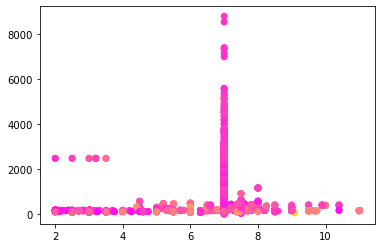

In [14]:
import matplotlib.pyplot as plt 

plt.scatter(modified_X[:, 0], modified_X[:, 1], c = modified_y, cmap = "spring")